In [1]:
import numpy as np
import pandas as pd
import os 
import time
import deepdish.io as dd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F

from svi import SVI
import models as m
import datasets as d

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
data = dd.load("sequenced_data_for_VAE_lenght-160_stride-10.h5")

In [4]:
X,y = data["X"], data["y"]

In [5]:
X

tensor([[0.1872, 0.1890, 0.1805,  ..., 0.1791, 0.1756, 0.1754],
        [0.1980, 0.1989, 0.1974,  ..., 0.1850, 0.1930, 0.1860],
        [0.2103, 0.2107, 0.2080,  ..., 0.1960, 0.2044, 0.2041],
        ...,
        [0.4694, 0.4644, 0.4707,  ..., 0.4877, 0.4774, 0.4771],
        [0.5260, 0.5163, 0.5141,  ..., 0.4935, 0.5005, 0.5110],
        [0.5704, 0.5643, 0.5629,  ..., 0.5024, 0.4991, 0.5269]],
       dtype=torch.float64)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=0.2, random_state=666)

In [7]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
train = d.H_alphaSequences(X_train, y_train)
test = d.H_alphaSequences(X_test, y_test)

In [9]:
cl = test.y

In [10]:
X_embedded = np.load("VAE-saved_model_and_losses/t-SNE-emebeded_test_data-DeepDenseVAE_mark_V_[160-256-128-15]_VDO_GNLL_400ep_lr-1e-4.npy")

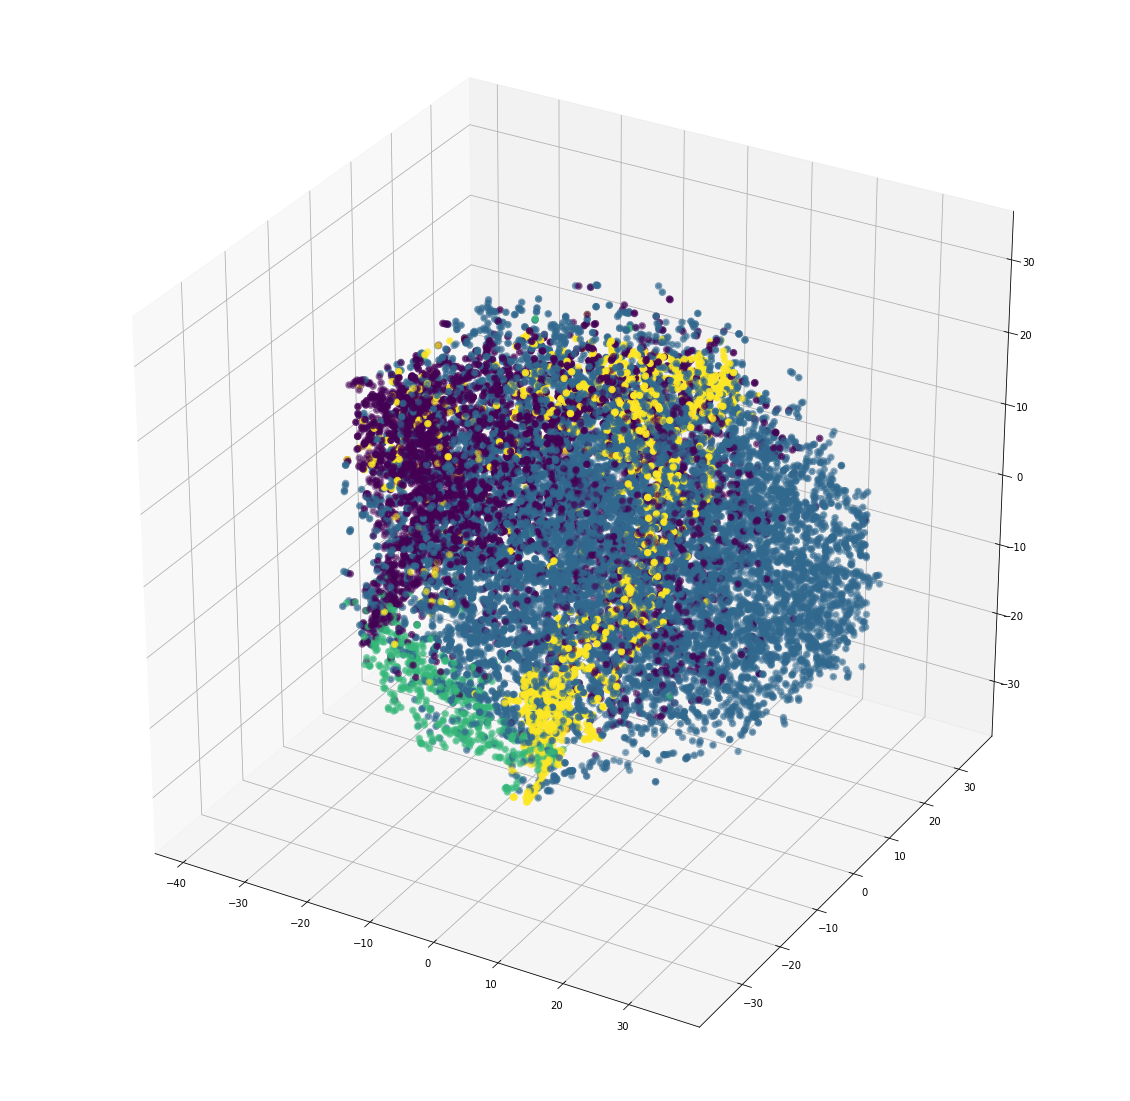

In [12]:
# t-SNE
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_embedded[:,0], X_embedded[:,1], X_embedded[:,2], c=cl, lw=3)

# CNN VAE

In [17]:
mod = torch.load("VAE-saved_model_and_losses/DeepConvVAE_ELU_NLL_250ep_lr-{1e-3, 1e-4}_bs-300.pt")

In [18]:
mod.eval()

DeepConvVAE_ELU(
  (encoder): Sequential(
    (0): Reshape()
    (1): Conv1d(1, 16, kernel_size=(6,), stride=(2,))
    (2): ELU(alpha=1.0)
    (3): Conv1d(16, 32, kernel_size=(4,), stride=(2,))
    (4): ELU(alpha=1.0)
    (5): Conv1d(32, 64, kernel_size=(4,), stride=(2,))
    (6): ELU(alpha=1.0)
    (7): Flatten()
    (8): VariationalLayer(
      (mu): Linear(in_features=1152, out_features=15, bias=True)
      (rho): Linear(in_features=1152, out_features=15, bias=True)
      (softplus): Softplus(beta=1, threshold=20)
    )
  )
  (decoder): Sequential(
    (0): Linear(in_features=15, out_features=1152, bias=True)
    (1): ELU(alpha=1.0)
    (2): Reshape()
    (3): ConvTranspose1d(64, 32, kernel_size=(4,), stride=(2,))
    (4): ELU(alpha=1.0)
    (5): ConvTranspose1d(32, 16, kernel_size=(4,), stride=(2,))
    (6): ELU(alpha=1.0)
    (7): ConvTransposeDecoderOutput(
      (mu): ConvTranspose1d(16, 1, kernel_size=(6,), stride=(2,))
      (rho): Linear(in_features=1248, out_features=1, bias

In [19]:
X_1, cl = test.X, test.y
Z_hat, mu, sigma = mod.encoder(X_1.to(device)) #.view(-1,28*28)
Z_hat = Z_hat.cpu().detach().numpy()
mu = mu.cpu().detach().numpy()

In [20]:
X_CNN = TSNE(n_components=3, verbose=True).fit_transform(mu)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 16736 samples in 0.028s...
[t-SNE] Computed neighbors for 16736 samples in 16.195s...
[t-SNE] Computed conditional probabilities for sample 1000 / 16736
[t-SNE] Computed conditional probabilities for sample 2000 / 16736
[t-SNE] Computed conditional probabilities for sample 3000 / 16736
[t-SNE] Computed conditional probabilities for sample 4000 / 16736
[t-SNE] Computed conditional probabilities for sample 5000 / 16736
[t-SNE] Computed conditional probabilities for sample 6000 / 16736
[t-SNE] Computed conditional probabilities for sample 7000 / 16736
[t-SNE] Computed conditional probabilities for sample 8000 / 16736
[t-SNE] Computed conditional probabilities for sample 9000 / 16736
[t-SNE] Computed conditional probabilities for sample 10000 / 16736
[t-SNE] Computed conditional probabilities for sample 11000 / 16736
[t-SNE] Computed conditional probabilities for sample 12000 / 16736
[t-SNE] Computed conditional probabilities for sa

In [21]:
#np.save("VAE-saved_model_and_losses/t-SNE-emebeded_test_data-DeepConvVAE_ELU_NLL_250ep_lr-{1e-3, 1e-4}_bs-300.npy", X_CNN)

In [13]:
X_CNN = np.load("VAE-saved_model_and_losses/t-SNE-emebeded_test_data-DeepConvVAE_ELU_NLL_250ep_lr-{1e-3, 1e-4}_bs-300.npy")

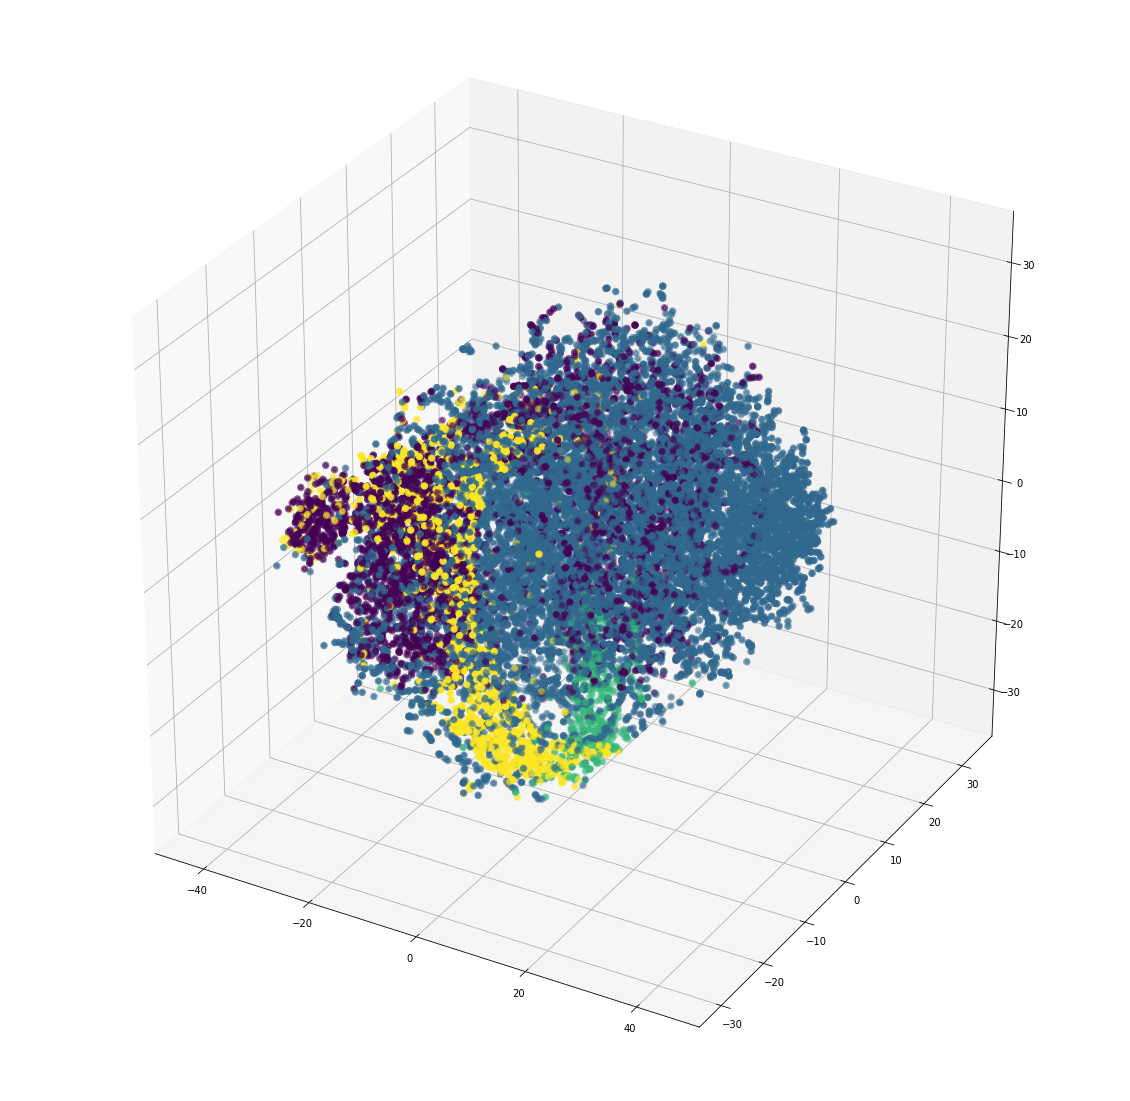

In [35]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_CNN[:,0], X_CNN[:,1], X_CNN[:,2], c=cl, lw=3)

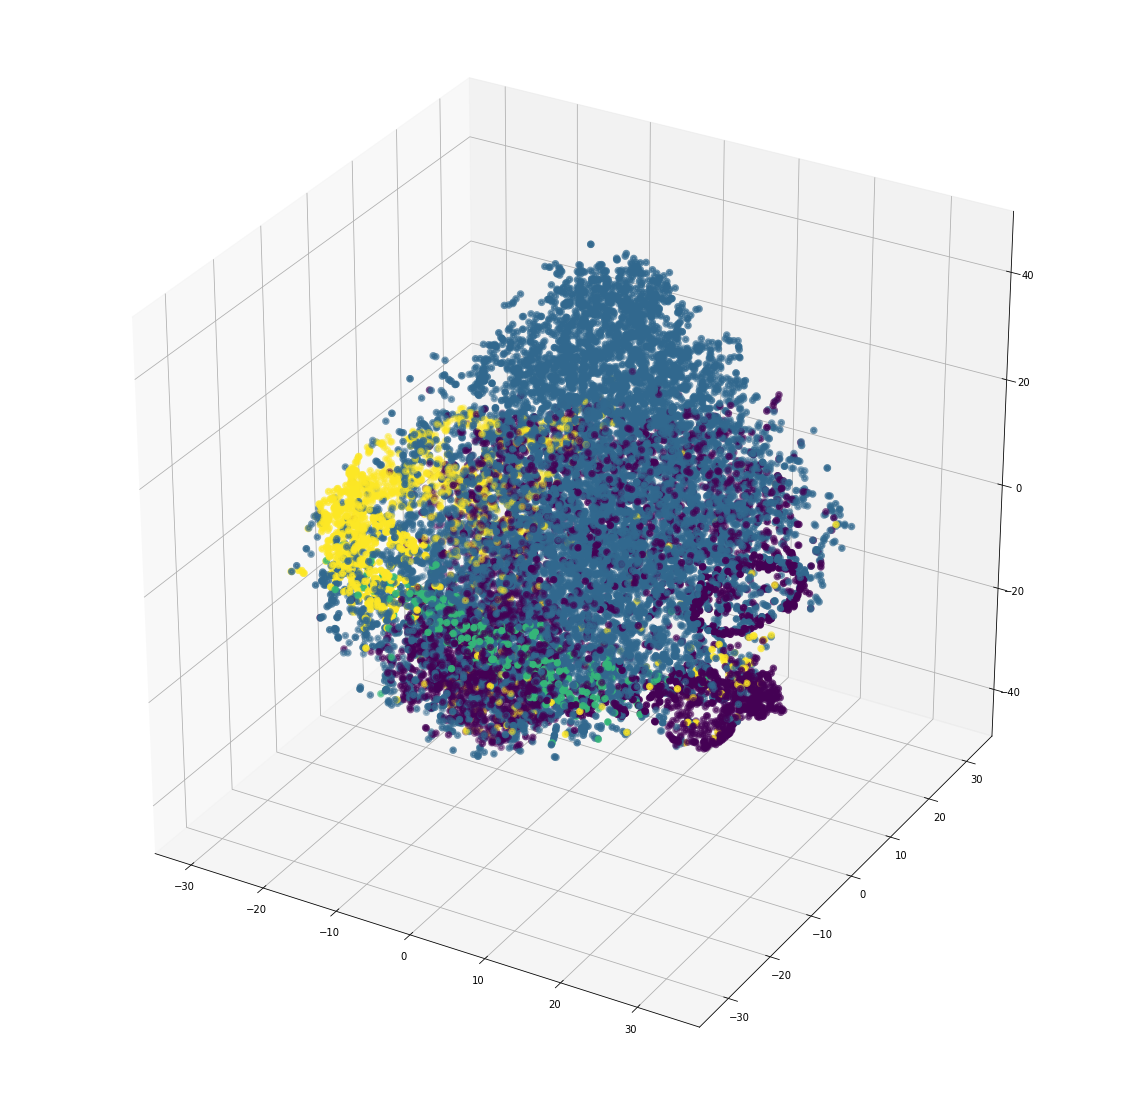

In [34]:
# t-SNE
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_CNN[:,1], X_CNN[:,2], X_CNN[:,0], c=cl, lw=3)

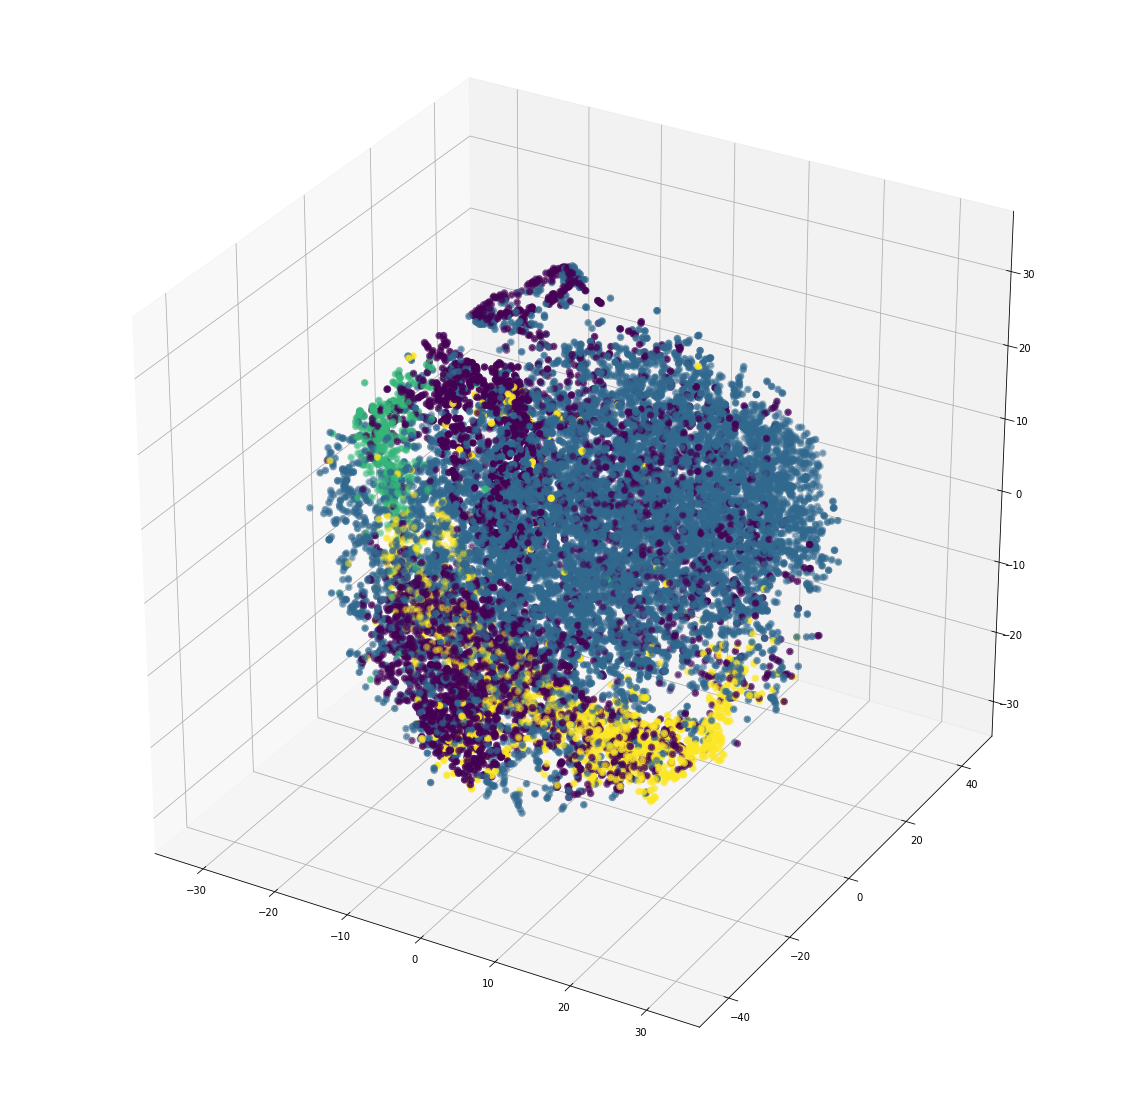

In [32]:
# t-SNE
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_CNN[:,2], X_CNN[:,0], X_CNN[:,1], c=cl, lw=3)

# CNN 2

In [12]:
mod2 = torch.load("VAE-saved_model_and_losses/DeepConvVAE_ReLU_NLL_200ep_lr-1e-4_bs-100.pt")

In [15]:
mod2.eval()

DeepConvVAE(
  (encoder): Sequential(
    (0): Reshape()
    (1): Conv1d(1, 16, kernel_size=(6,), stride=(2,))
    (2): ReLU()
    (3): Conv1d(16, 32, kernel_size=(4,), stride=(2,))
    (4): ReLU()
    (5): Conv1d(32, 64, kernel_size=(4,), stride=(2,))
    (6): ReLU()
    (7): Flatten()
    (8): VariationalLayer(
      (mu): Linear(in_features=1152, out_features=15, bias=True)
      (rho): Linear(in_features=1152, out_features=15, bias=True)
      (softplus): Softplus(beta=1, threshold=20)
    )
  )
  (decoder): Sequential(
    (0): Linear(in_features=15, out_features=1152, bias=True)
    (1): ReLU()
    (2): Reshape()
    (3): ConvTranspose1d(64, 32, kernel_size=(4,), stride=(2,))
    (4): ReLU()
    (5): ConvTranspose1d(32, 16, kernel_size=(4,), stride=(2,))
    (6): ReLU()
    (7): ConvTransposeDecoderOutput(
      (mu): ConvTranspose1d(16, 1, kernel_size=(6,), stride=(2,))
      (rho): Linear(in_features=1248, out_features=1, bias=True)
      (flatten): Flatten()
      (flatten_mu)

In [13]:
X_1, cl = test.X, test.y
Z_hat, mu, sigma = mod2.encoder(X_1.to(device)) #.view(-1,28*28)
Z_hat = Z_hat.cpu().detach().numpy()
mu = mu.cpu().detach().numpy()

In [16]:
X_CNN2 = TSNE(n_components=3, verbose=True).fit_transform(mu)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 16736 samples in 0.029s...
[t-SNE] Computed neighbors for 16736 samples in 13.360s...
[t-SNE] Computed conditional probabilities for sample 1000 / 16736
[t-SNE] Computed conditional probabilities for sample 2000 / 16736
[t-SNE] Computed conditional probabilities for sample 3000 / 16736
[t-SNE] Computed conditional probabilities for sample 4000 / 16736
[t-SNE] Computed conditional probabilities for sample 5000 / 16736
[t-SNE] Computed conditional probabilities for sample 6000 / 16736
[t-SNE] Computed conditional probabilities for sample 7000 / 16736
[t-SNE] Computed conditional probabilities for sample 8000 / 16736
[t-SNE] Computed conditional probabilities for sample 9000 / 16736
[t-SNE] Computed conditional probabilities for sample 10000 / 16736
[t-SNE] Computed conditional probabilities for sample 11000 / 16736
[t-SNE] Computed conditional probabilities for sample 12000 / 16736
[t-SNE] Computed conditional probabilities for sa

In [17]:
#np.save("VAE-saved_model_and_losses/t-SNE-emebeded_test_data-DeepConvVAE_ReLU_NLL_200ep_lr-1e-4_bs-100.npy", X_CNN2)

In [18]:
X_CNN2 = np.load("VAE-saved_model_and_losses/t-SNE-emebeded_test_data-DeepConvVAE_ReLU_NLL_200ep_lr-1e-4_bs-100.npy")

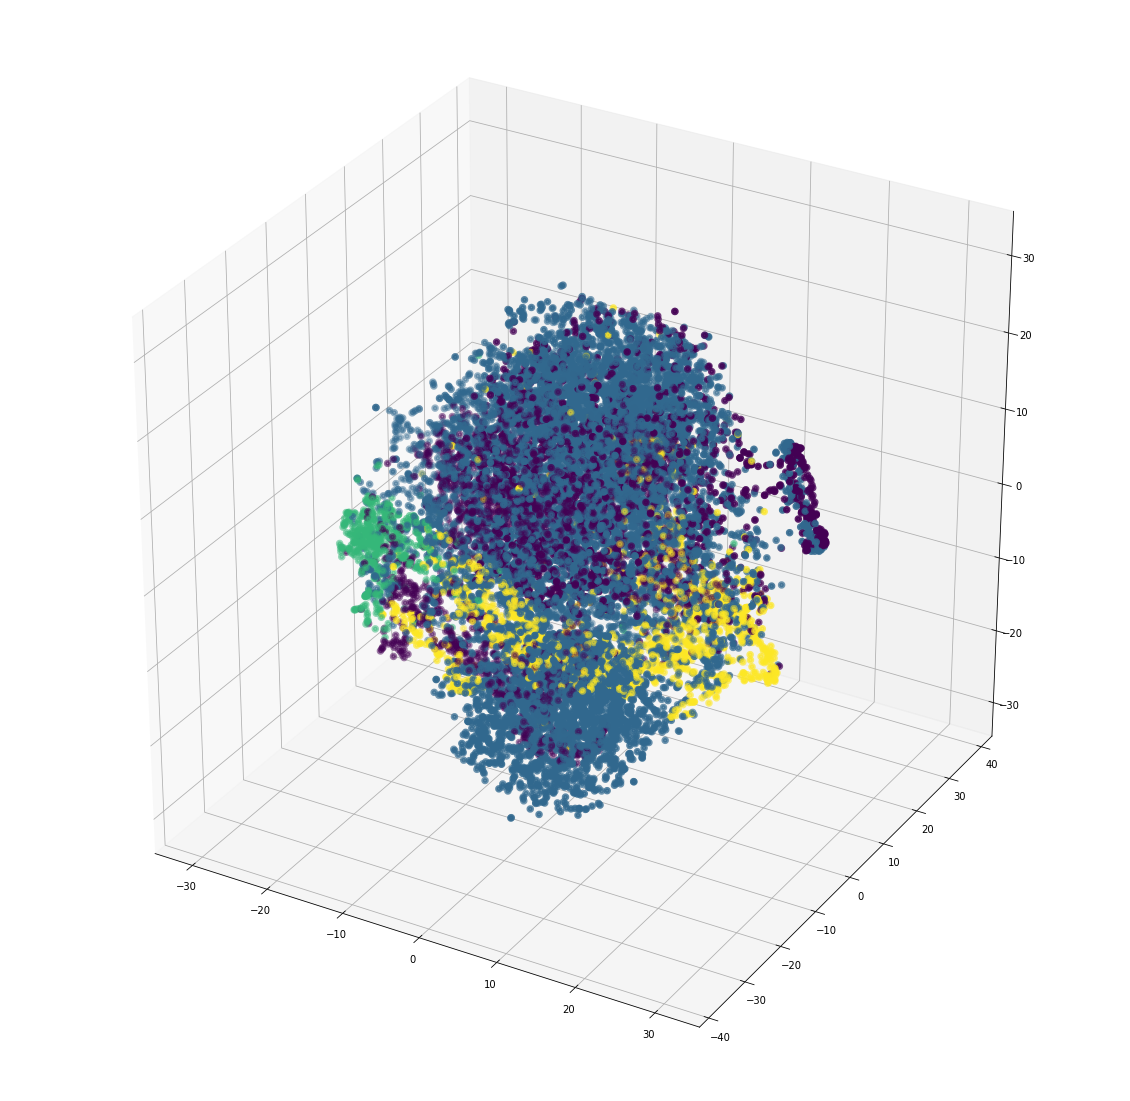

In [19]:
# t-SNE
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_CNN2[:,0], X_CNN2[:,1], X_CNN2[:,2], c=cl, lw=3)

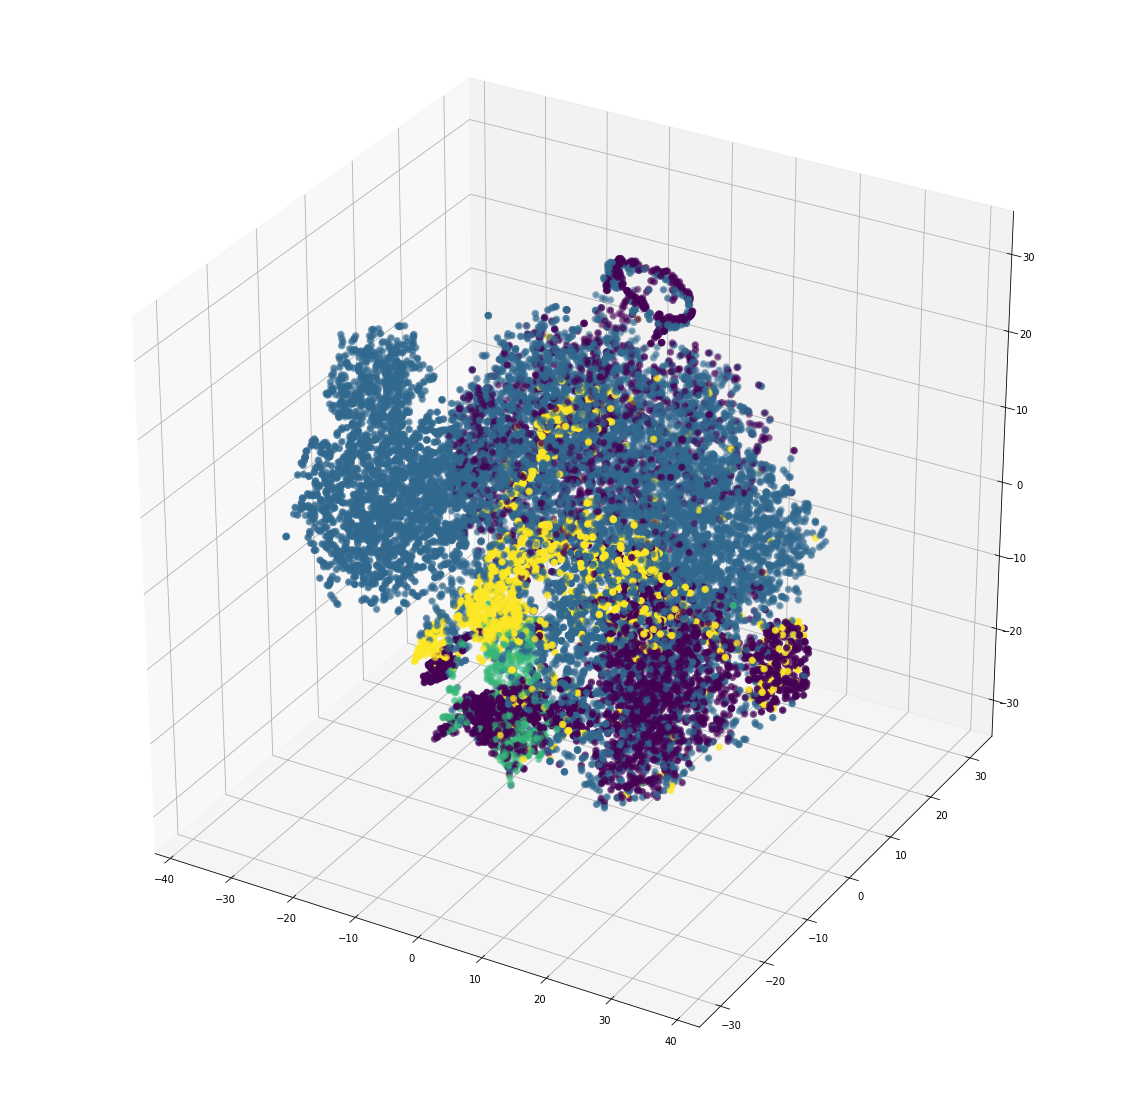

In [20]:
# t-SNE
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_CNN2[:,1], X_CNN2[:,2], X_CNN2[:,0], c=cl, lw=3)

# LSTM VAE

In [22]:
mod3 = torch.load("VAE-saved_model_and_losses/DeepLSTM_VAE_NLL_440ep_hidden-128_lr-{1e-3, 1e-4}_bs-300.pt")

In [23]:
mod3.eval()

DeepLSTM_VAE(
  (encoder_reshape): Reshape()
  (encoder_lstm): LSTM(1, 128)
  (encoder_output): VariationalLayer(
    (mu): Linear(in_features=128, out_features=15, bias=True)
    (rho): Linear(in_features=128, out_features=15, bias=True)
    (softplus): Softplus(beta=1, threshold=20)
  )
  (decoder_hidden): Linear(in_features=15, out_features=128, bias=True)
  (decoder_lstm): LSTM(1, 128)
  (decoder_output): RecurrentDecoderOutput(
    (mu): Linear(in_features=128, out_features=1, bias=True)
    (rho): Linear(in_features=20480, out_features=1, bias=True)
    (softplus): Softplus(beta=1, threshold=20)
  )
)

In [24]:
X_1, cl = test.X, test.y
Z_hat, mu, sigma = mod3.encoder(X_1.to(device))
mu = mu.cpu().detach().numpy()

In [25]:
X_LSTM = TSNE(n_components=3, verbose=True).fit_transform(mu)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 16736 samples in 0.032s...
[t-SNE] Computed neighbors for 16736 samples in 2.601s...
[t-SNE] Computed conditional probabilities for sample 1000 / 16736
[t-SNE] Computed conditional probabilities for sample 2000 / 16736
[t-SNE] Computed conditional probabilities for sample 3000 / 16736
[t-SNE] Computed conditional probabilities for sample 4000 / 16736
[t-SNE] Computed conditional probabilities for sample 5000 / 16736
[t-SNE] Computed conditional probabilities for sample 6000 / 16736
[t-SNE] Computed conditional probabilities for sample 7000 / 16736
[t-SNE] Computed conditional probabilities for sample 8000 / 16736
[t-SNE] Computed conditional probabilities for sample 9000 / 16736
[t-SNE] Computed conditional probabilities for sample 10000 / 16736
[t-SNE] Computed conditional probabilities for sample 11000 / 16736
[t-SNE] Computed conditional probabilities for sample 12000 / 16736
[t-SNE] Computed conditional probabilities for sam

In [26]:
np.save("VAE-saved_model_and_losses/t-SNE-emebeded_test_data-DeepLSTM_VAE_NLL_440ep_hidden-128_lr-{1e-3, 1e-4}_bs-300.npy", X_LSTM)

In [36]:
X_LSTM = np.load("VAE-saved_model_and_losses/t-SNE-emebeded_test_data-DeepLSTM_VAE_NLL_440ep_hidden-128_lr-{1e-3, 1e-4}_bs-300.npy")

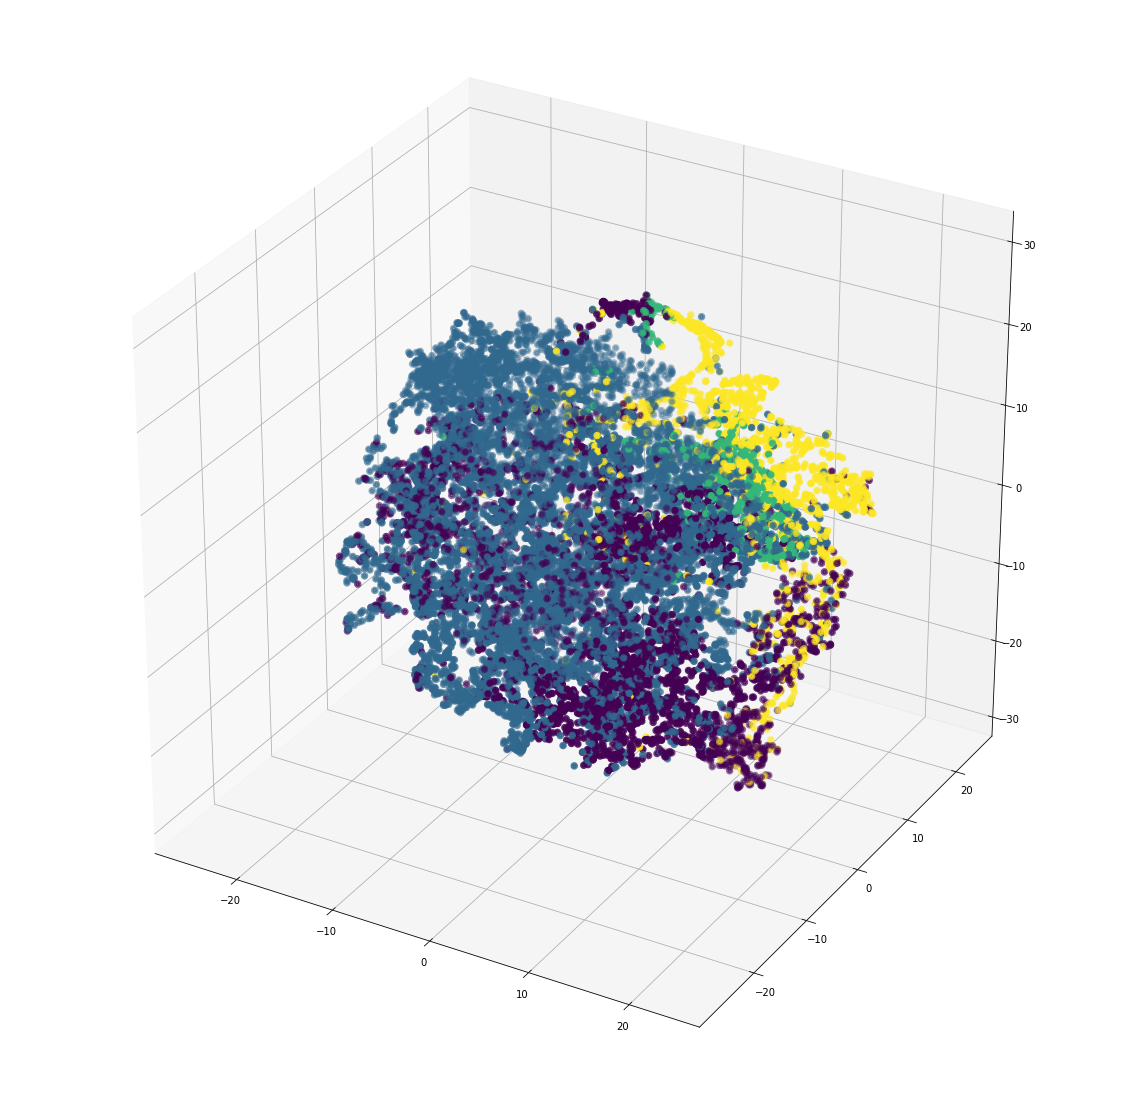

In [37]:
# t-SNE
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_LSTM[:,0], X_LSTM[:,1], X_LSTM[:,2], c=cl, lw=3)

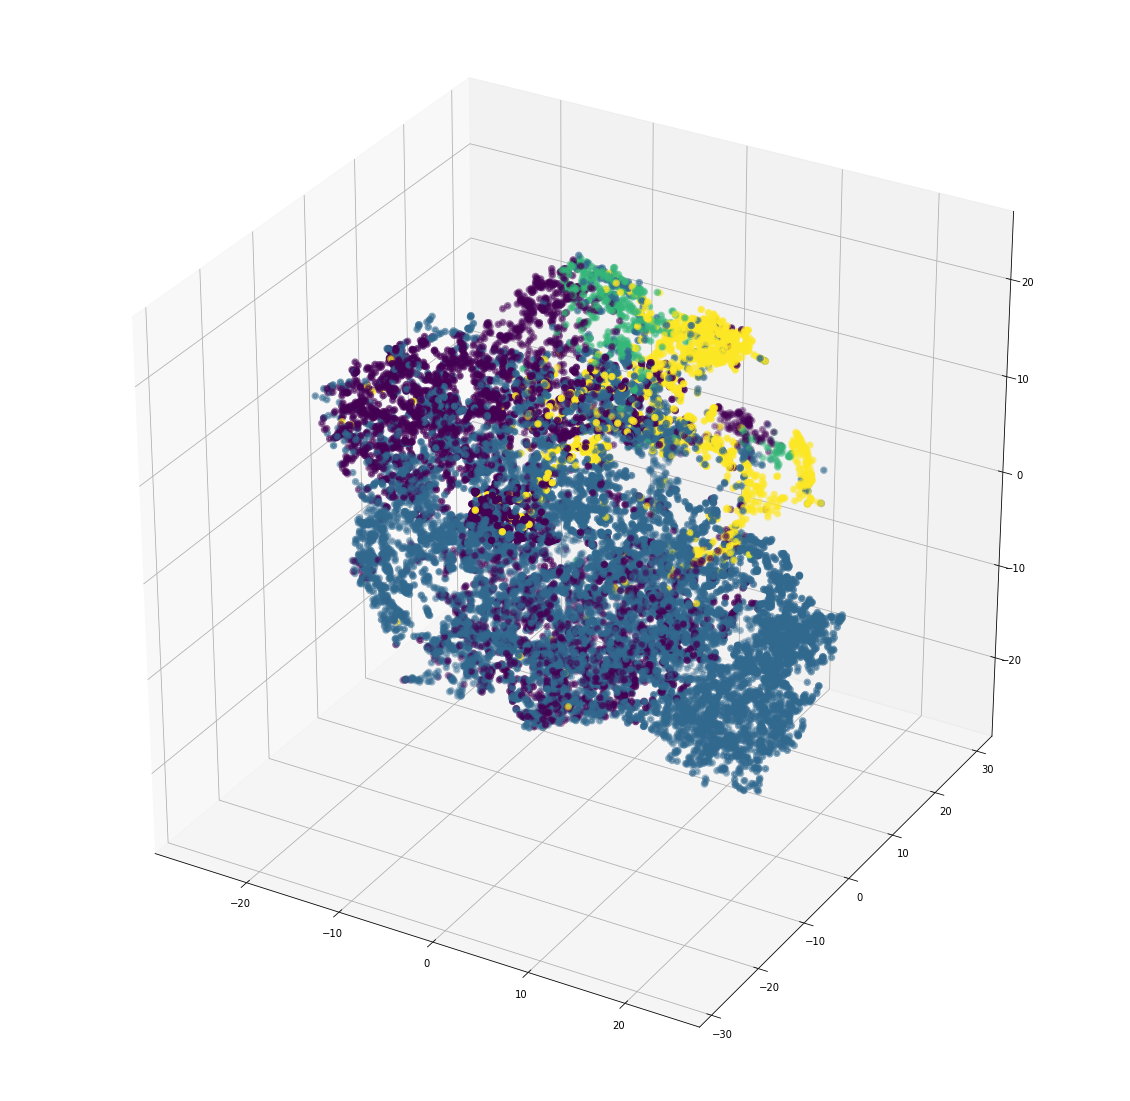

In [38]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_LSTM[:,1], X_LSTM[:,2], X_LSTM[:,0], c=cl, lw=3)

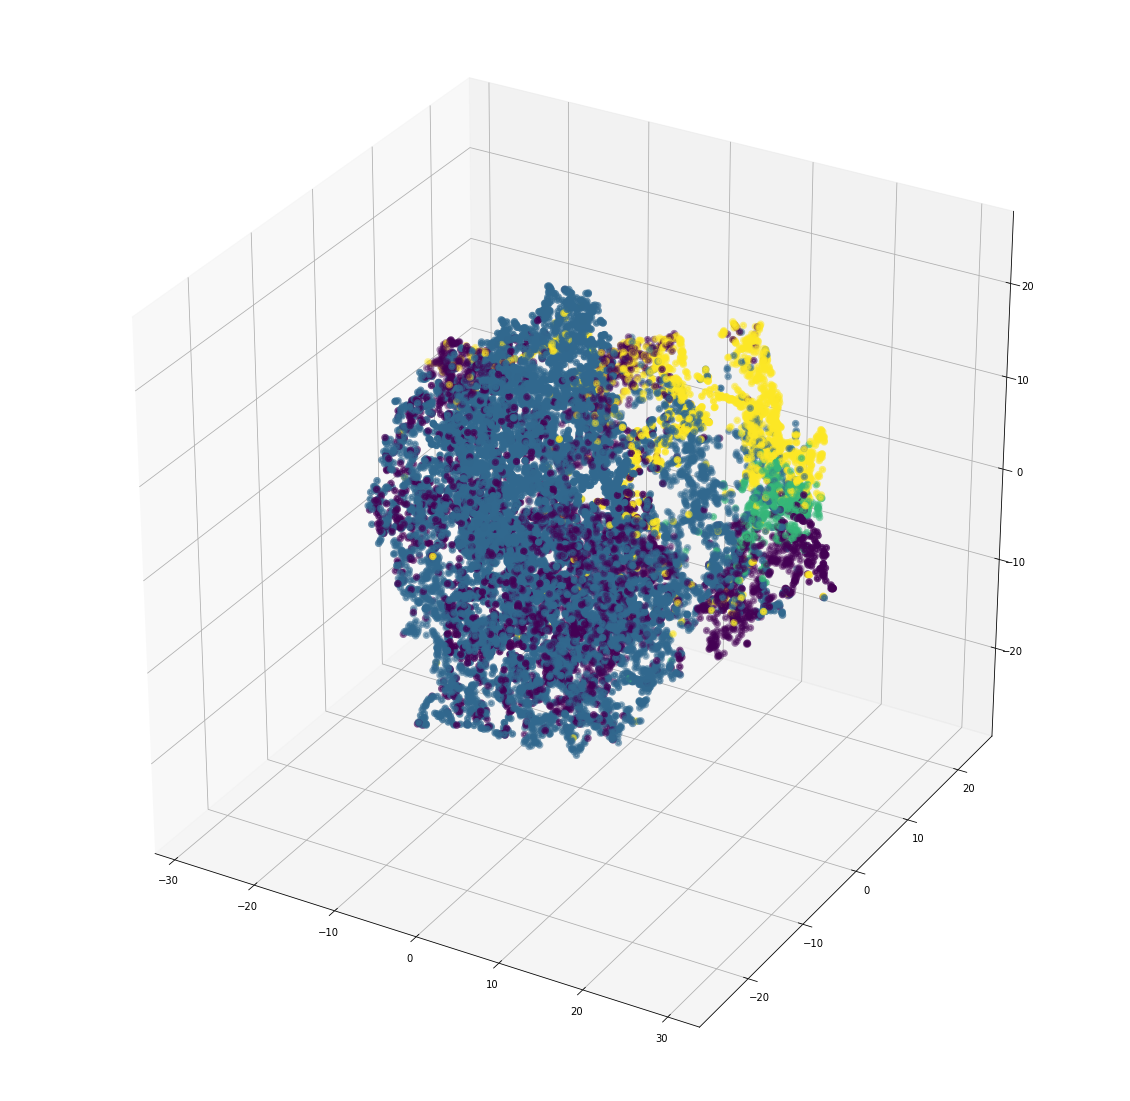

In [39]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_LSTM[:,2], X_LSTM[:,0], X_LSTM[:,1], c=cl, lw=3)

In [40]:
X_LSTM2 = TSNE(perplexity=15, n_components=3, verbose=True).fit_transform(mu)

[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 16736 samples in 0.029s...
[t-SNE] Computed neighbors for 16736 samples in 1.793s...
[t-SNE] Computed conditional probabilities for sample 1000 / 16736
[t-SNE] Computed conditional probabilities for sample 2000 / 16736
[t-SNE] Computed conditional probabilities for sample 3000 / 16736
[t-SNE] Computed conditional probabilities for sample 4000 / 16736
[t-SNE] Computed conditional probabilities for sample 5000 / 16736
[t-SNE] Computed conditional probabilities for sample 6000 / 16736
[t-SNE] Computed conditional probabilities for sample 7000 / 16736
[t-SNE] Computed conditional probabilities for sample 8000 / 16736
[t-SNE] Computed conditional probabilities for sample 9000 / 16736
[t-SNE] Computed conditional probabilities for sample 10000 / 16736
[t-SNE] Computed conditional probabilities for sample 11000 / 16736
[t-SNE] Computed conditional probabilities for sample 12000 / 16736
[t-SNE] Computed conditional probabilities for sam

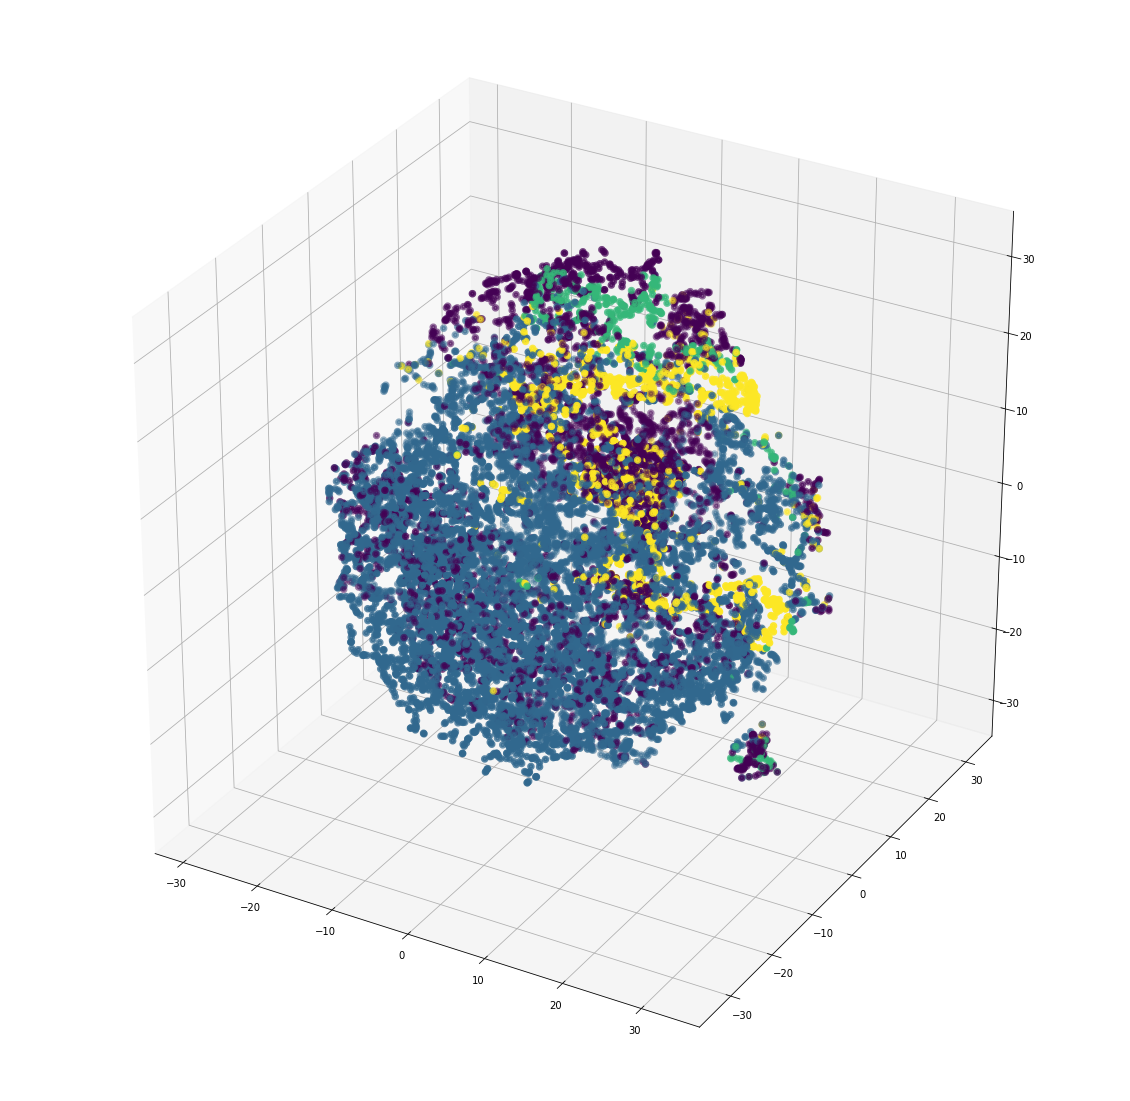

In [43]:
# t-SNE
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_LSTM2[:,1], X_LSTM2[:,2], X_LSTM2[:,0], c=cl, lw=3)